In [339]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

In [340]:
average_kmph = 40

In [341]:
class battery(Agent):
    num_of_batteries = 0
    degradation_rate = 0.00025 #Ini didapatkan dari standar baterai HP, secara umum setelah 800 charge cycle, battery health tinggal 80%/0.8

    def __init__(self, unique_id, model, max_cap = 2600, health = 1):
        super().__init__(unique_id,model)
        # baterai memiliki tiga parameter sebagai berikut:
        # max_cap: kapasitas maksimum baterai, dalam satuan Watt-hour (Baterai gogoro 1.3 kWh, ada 2 biji)
        # health: kesehatan baterai, real_cap = max_cap * health. Nilai health berkisar antara 0-1. By default 1.
        # charge: isi dari baterai sekarang, charge harus < real_cap. Ketika baterai diciptakan, baterai terisi penuh
        self.max_cap = max_cap
        self.health = health
        self.real_cap = max_cap*health
        self.charge = self.real_cap
        battery.num_of_batteries += 1
        self.id = battery.num_of_batteries
        self.position = None
        self.alive = True
        self. distance_ = None   
    def degrade(self):
        self.health -= battery.degradation_rate #Diasumsikan degradation rate dari setiap baterai sama

    def consume_charge(self):
        '''
        Saat ini, cons_charge akan ditentukan melalui aproksimasi kasar: karena time step 1 menit, maka dengan menggunakan asumsi kecepatan motor sebesar 40 km/jam, pada setiap step agent akan bergerak sejauh 2/3 km. Selain itu, diketahui pula untuk 170 km, diperlukan energi sebesar 2600 Wh. Akan didapatkan penggunaan sebesar 15 Wh/km. Berarti akan dihabiskan energi sebesar 10Wh per menit/step
        '''
        cons_charge = average_kmph*15.3 #Wh
        self.charge = max(0.0, self.charge - cons_charge)

        #TODO: check for error, remove this line to improve performance
        if self.charge < 0:
            raise Exception("Charge tidak mungkin bernilai negatif")

    def charging(self):
        charge_rate = 860 #Wh
        self.charge += charge_rate
        if self.charge > self.real_cap :
            self.charge = self.real_cap

In [342]:
class driver(Agent):
    def __init__(self, unique_id, model, batteries = None): 
        super().__init__(unique_id,model)
        # Driver Character
        self.distance_daily = 130 #km
        self.distance_ = self.distance_daily + abs(np.random.normal(loc = 0, scale = 8))
        self.move = True 
        #self.finish = False
        self.position = None
        
        #Assign baterai
        if batteries == None:
            self.batteries = None
        else:
            self.batteries = batteries
        self.batteries.position = 'driver'+str(unique_id)
        
        # Decision to charge
        self.charge_ = False

        #Sekarang akan ditentukan status driver
        self.alive = False
        if self.batteries != None:
            if self.batteries.charge > 0:
                self.alive = True

        #Biar ga error
        self.charge = None
        self.inventory_full = []
        self.inventory_empty = []
        self.cp_full = []
        self.cp_empty = []
     #Target station
        self.target_station = None
    
    def set_target_station(self):
        potential_station = self.model.stations
        return potential_station[np.random.randint(0,len(potential_station))]


    def stop_move(self):
        if self.distance_ <= 0 :
            return False
        else :
            return True
        # charge below average 
        
    def prob_charge(self):
        decs = np.random.rand()
        if decs < (1-(self.batteries.charge/self.batteries.real_cap)):
            return True 
        else :
            return False

    def change_battery(self):
        #Baterai kosong
        empty_bat = self.batteries
        self.target_station = self.set_target_station()
        # Unique ID dari station
        #Cek tipe station, dengan inventory atau tidak
        if self.target_station.inventory_size > 0:
            #Ngecek station punya baterai penuh atau tidak:
            if len(self.target_station.inventory_full) > 0:
                empty_bat.position = 'charging'+str(self.target_station.unique_id)
                self.target_station.inventory_empty.append(empty_bat)
                self.batteries = self.target_station.inventory_full[0]
                self.target_station.inventory_full.remove(self.batteries)

                # Unique ID dari station
                self.batteries.position =  'driver'+str(self.unique_id)
                self.target_station = None

            elif len(self.target_station.inventory_full) == 0:
               #print("Station habis")
                if self.batteries.charge <=0:
                    self.batteries.charge = 0
                    self.alive = False
                else : 
                    self.target_station = self.set_target_station()

        else:
            if len(self.target_station.cp_full) > 0:
                #Tukar baterai
                #empty_bat.degrade()
                empty_bat.position = 'charging'+str(self.target_station.unique_id)
                self.target_station.cp_empty.append(empty_bat)
                self.batteries = self.target_station.cp_full[0]
                self.target_station.cp_full.remove(self.batteries)
                
                #Hilangkan target station
                self.target_station = None
            elif (len(self.target_station.cp_full) == 0):
                if self.batteries.charge == 0:
                    self.alive = False
                else:
                    self.set_target_station()

    def reset_distance(self):
        return self.distance_daily + abs(np.random.normal(loc = 0, scale = 8))

    def step(self):
        if self.move == True :
            if self.batteries.charge < (average_kmph*15.3):
                self.distance_ -= (self.batteries.charge/15.3) 
                self.batteries.consume_charge()
            else : 
                self.batteries.consume_charge()
                self.distance_ -= 40 

            self.charge_ = self.prob_charge()
            self.move = self.stop_move()

        if self.charge_ == True :
            self.change_battery()

        if  self.distance_ <= 0:
            if (self.model.time%24==1):
                self.distance_ = self.reset_distance()
                self.move = True

In [343]:
class station(Agent):
    '''
    Di sini, baterai akan disimpan di inventory dan juga charging port.
    inventory_full: List baterai yang terisi penuh
    inventory_empty: List baterai yang kosong tapi belum bisa di cas di charging port (kosong bukan berarti 0, tapi tidak terisi penuh)
    charging_port: List baterai yang sedang di cas
    '''
    def __init__(self, unique_id, model, inventory_size = 40,charging_port_size=10, assigned_batteries = None):
        super().__init__(unique_id,model)
        
        #Assign spesifikasi
        self.charging_port_size = charging_port_size
        self.inventory_size = inventory_size
        self.charge_rate = 860 #Wh/menit
        self. distance_ = None
        #Add array inventory dan charging port
        self.inventory_full = []
        self.inventory_empty = []

        #cp dipisahkan untuk memudahkan pemodelan nantinya
        self.cp_full = []
        self.cp_empty = []

        #Biar ga error
        self.charge = None
        self.alive = None
        self.position = None

        if assigned_batteries == None:
            pass
        else:
            #Di cek dulu apakah assigned_batteries melebihi kapasitas station
            if len(assigned_batteries) > (self.charging_port_size+ self.inventory_size):
                raise Exception("Baterai yang di assign di station terlalu banyak")
            else:
                #Kita akan assign battery, pertama2 akan di cek dulu apakah terdapat error, lalu baru di cek apakah baterai penuh atau kosong
                for i in assigned_batteries:
                    if i.charge > i.real_cap:
                        raise Exception("Isi baterai tidak dapat melebihi kapasitas sebenarnya")
                    elif i.charge < 0:
                        raise Exception("Isi baterai tidak boleh negatif")
                    elif i.charge == i.real_cap:
                        #Kalau baterai penuh, maka akan di assign di inventory_full, kalau inventory penuh, assign ke charging port
                        if (len(self.inventory_full) + len(self.inventory_empty)) < self.inventory_size:
                            self.inventory_full.append(i)
                        else:
                            self.cp_full.append(i)
                    elif i.charge < i.real_cap:
                        #Kalau baterai kosong, maka akan di assign ke charging port, kalau charging port penuh, di assign ke inventory_empty
                        if (len(self.cp_full) + len(self.cp_empty)) < self.charging_port_size:
                            self.cp_empty.append(i)
                        else:
                            self.inventory_empty.append(i)


    def charge_batteries(self):
        for bat in self.cp_empty:
            #Biar charge tidak melewati real capacity
            bat.charge = min(bat.real_cap, bat.charge + self.charge_rate)

            #TODO: temporary check for error, remove this to improve computational performance
            if bat.charge > bat.real_cap:
                raise Exception("Ada error dengan fungsi minimum")

            #Kalau baterainya penuh, pindahkan dari cp_empty ke cp_full
            elif bat.charge == bat.real_cap:
                self.cp_full.append(bat)
                self.cp_empty.remove(bat)

    def switch_cp_inventory(self):
        #Tentukan dulu mana yang lebih sedikit, baterai kosong di inventory atau baterai penuh di charging port
        min_index = min(len(self.inventory_empty), len(self.cp_full))

        if min_index > 0:
            empty_bats = self.inventory_empty[0:min_index] #Baterai kosong
            full_bats = self.cp_full[0:min_index] # Baterai penuh

            #degradasi baterai dan tukar baterai
            for bat in empty_bats:
                #bat.degrade()
                bat.position = 'charging'+str(self.unique_id)
                self.cp_empty.append(bat)
                self.inventory_empty.remove(bat)

            #tukar full battery
            for bat in full_bats:
                bat.position = 'inventory'+str(self.unique_id)
                self.inventory_full.append(bat)
                self.cp_full.remove(bat)
            
    def check_capacity(self):
        for bat in self.inventory_full:
            if bat.charge < bat.real_cap :
                #bat.degrade()
                bat.position = 'charging'+str(self.unique_id)
                self.cp_empty.append(bat)
                self.inventory_full.remove(bat)
        for bat in self.inventory_empty:
            if bat.charge < bat.real_cap :
                #bat.degrade()
                bat.position = 'charging'+str(self.unique_id)
                self.cp_empty.append(bat)
                self.inventory_empty.remove(bat)

    def step(self):
        #Bagian ini untuk model yang punya inventory
        if self.inventory_size > 0:
            self.check_capacity()
            self.charge_batteries()
            self.switch_cp_inventory()
        
        #Bagian ini untuk yang tidak punya inventory
        else:
            self.charge_batteries()


In [344]:
class switching_model(Model):
    '''
    inv_size: Ukuran inventory station
    cp_size: Ukuran charging port
    num_of_motorist: Jumlah motor
    num_of_stations: Jumlah station
    '''
    def __init__(self,num_of_motorist, num_of_stations, inv_size, cp_size):
    
        #Jumlah motor
        self.num_of_motorist = num_of_motorist
        #Jumlah station
        self.num_of_stations = num_of_stations
        #Jumlah inventory
        self.inv_size = inv_size
        #Jumlah charging port
        self.cp_size = cp_size
        #Jumlah baterai = jumlah motor yang ada + jumlah station*Kapasitas station
        self.num_of_batteries = num_of_motorist + num_of_stations*(self.inv_size + self.cp_size)
        #Add Time
        self.time = -1
        #TODO:Nanti schedule harus coba dimodifikasi sendiri
        self.schedule = RandomActivation(self)
        self.alive = True       
        #Id agent
        self.current_id = -1

        #Array untuk nyimpen agent
        self.batteries = []
        self.motorists = []
        self.stations = []

        #Create battery
        for i in range(self.num_of_batteries):
            #Create new battery
            new_id = self.next_id()
            bat = battery(unique_id = new_id,model = self)

            self.schedule.add(bat)
            #Tambahkan ke list baterai
            self.batteries.append(bat)


        #Create motorist
        for i in range(self.num_of_motorist):
            #Create new motorist
            new_id = self.next_id()
            mot = driver(new_id,self,batteries=self.batteries[i])


            #Place agent
            self.schedule.add(mot)
            #Tambahkan ke list motor
            self.motorists.append(mot)

        #Create stations
        for i in range(self.num_of_stations):

            #Create station + assign batteries
            new_id = self.next_id()
            assigned_= [bat for bat in self.batteries[self.num_of_motorist+i*(self.inv_size+self.cp_size):self.num_of_motorist+(i+1)*(self.inv_size+self.cp_size)]]
            stat = station(new_id, self, assigned_batteries = assigned_)
            for bat in assigned_ :
                bat.position = 'charging-inventory'+str(new_id)

            self.schedule.add(stat)
            #Tambahkan ke list station
            self.stations.append(stat)

        #TODO: Lengkapi data collector
        #TODO: Buat jumlah motorist yang masih hidup
        self.datacollector = DataCollector(
            agent_reporters={
                "Position": "position",
                "Charge": "charge",
                'Alive' : 'alive',
                'Distance' : 'distance_'
            }
        )

    def step(self):
        self.time += 1
        self.datacollector.collect(self)
        self.schedule.step()

In [345]:
model = switching_model(num_of_motorist= 10, num_of_stations=4, inv_size=5, cp_size  = 5)
days = 30
#Di sini satuan waktunya dalam menit
num_of_steps = 24*days # 2 day
for i in range(num_of_steps):
    model.step()

In [346]:
agent_data = model.datacollector.get_agent_vars_dataframe()


In [347]:
agent_data.to_csv('test.csv')

<AxesSubplot:xlabel='Step'>

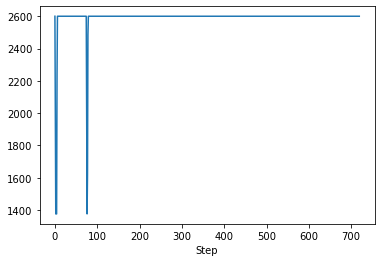

In [356]:
battery_id = 7
battery_energy = agent_data.xs(battery_id, level = "AgentID")["Charge"]
battery_energy.plot()